In [ ]:
#default_exp data

In [ ]:
#export
from fastai2.basics import *
# from fastai2.data.all import *

In [ ]:
from nbdev.showdoc import *

In [ ]:
from fastai2.data.external import *

In [ ]:
# #export
# from zipfile import ZipFile 

# Timeseries Data
> Basic functions to read timeseries files like `.arff` and `.ts` files.

In [ ]:
#export
class TSData():
    "Class that loads .arff (soon .ts) files and returns a tuple (data.x , self.y)"
    "self.x is a list of 2D array with a shape (n_samples, nb_channels, sequence_length) "
    "self.y is a 1D array as y (i.e. label) with a shape (n_samples)"
    "for the NATOPS_Train.arff file, the result will be : x(180, 24, 51) and y(180)"
    # def __init__(self):
    #     self.x = self.y = self.dsname = self.fnames = [],[],[],[]
    
    def __init__(self, fnames, has_targets=True, fill_missing='NaN'):
        # self.x = self.y = self.dsname = [],[],[]
        self.x = []
        self.y = []
        self.dsname = []
        self.fnames = fnames
        self.has_targets = has_targets
        self.fill_missings = fill_missing
    
    def __repr__(self): return f"{self.__class__.__name__}:\n Datasets names (concatenated): {self.dsname}\n Filenames:                     {self.fnames}\n Data shape: {self.x.shape}\n Targets shape: {self.y.shape}\n Nb Samples: {self.x.shape[0]}\n Nb Channels:           {self.x.shape[1]}\n Sequence Length: {self.x.shape[2]}"
    
    def get_x(self, as_list=True): return(list(self.x))
    def get_y(self): return(self.y)
    def get_items(self): return [(item, str(label)) for (item, label) in zip(list(self.x), self.y)]
    def get_lists(self): return (list(self.x), self.y)
    def __getitem__(self, i): return (self.x[i], str(self.y[i]))
    def get_nb_samples(self): return self.x.shape[0]

    def sample(self, cut):
        n=self.x.shape[0]
        rand_idx = L(int(i) for i in torch.randperm(n))
        idxs = rand_idx[:cut]
        return [(self.x[i], str(self.y[i])) for i in idxs]

    @property
    def sizes(self): return (self.x.shape, self.y.shape)
    
    @property
    def n_channels(self): return (self.x.shape[1])
    
    def _load_arff(self, fname, has_targets=True, fill_missing='NaN'):
        "load an .arff file and return a tupple of 2 numpy arrays: "
        "x : array with a shape (n_samples, nb_channels, sequence_length)"
        "y : array with a shape (n_samples)"
        "for the NATOPS_Train.arff  the result will be : x(180, 24, 51) and y(180)"
        
        instance_list = []
        class_val_list = []
        data_started = False
        is_multi_variate = False
        is_first_case = True
        
        with open(fname, 'r', encoding="utf8") as f:
            for line in f:
                if line.strip():
                    if is_multi_variate is False and "@attribute" in line.lower() and "relational" in line.lower():
                        is_multi_variate = True
                    if "@data" in line.lower():
                        data_started = True
                        continue
                    # if the 'data tag has been found, the header information has been cleared and now data can be loaded
                    if data_started:
                        line = line.replace("?", fill_missing)
                        if is_multi_variate:
                            if has_targets:
                                line, class_val = line.split("',")
                                class_val_list.append(class_val.strip())
                            dimensions = line.split("\\n")
                            dimensions[0] = dimensions[0].replace("'", "")

                            if is_first_case:
                                for d in range(len(dimensions)):
                                    instance_list.append([])
                                is_first_case = False

                            for dim in range(len(dimensions)):
                                instance_list[dim].append(np.array(dimensions[dim].split(','), dtype=np.float32))
#                                 instance_list[dim].append(np.fromiter(dimensions[dim].split(','), dtype=np.float32))
                        else:
                            if is_first_case:
                                instance_list.append([])
                                is_first_case = False

                            line_parts = line.split(",")

                            if has_targets:
                                instance_list[0].append(np.array(line_parts[:len(line_parts)-1], dtype=np.float32))

                                class_val_list.append(line_parts[-1].strip())
                            else:
                                instance_list[0].append(np.array(line_parts[:len(line_parts)-1], dtype=np.float32))

        #instance_list has a shape of (dimensions, nb_samples, seq_lenght)
        #for the NATOPS_Train.arff it would be (24, 180, 51)
        #convert python list to numpy array and transpose the 2 first dimensions -> (180, 24, 51)
        x = np.asarray(instance_list).transpose(1,0,2) 
        
        if has_targets:
            y = np.asarray(class_val_list)       
            return x, y
        else:
            return x, [None*x.shape[0]]

    @classmethod
    def from_arff(self, fnames, has_targets=True, fill_missing='NaN'):
        "load an .arff file and return a tupple of 2 numpy arrays: "
        "x : array with a shape (n_samples, nb_channels, sequence_length)"
        "y : array with a shape (n_samples)"
        "for the NATOPS_Train.arff  the result will be : x(180, 24, 51) and y(180)"
        data = self(fnames, has_targets=has_targets, fill_missing=fill_missing)
        if isinstance(fnames, list):
            data.x = []
            data.y = []
            data.dsname = []
            data.fnames = []
            xs,ys = [],[]
            for i, fn in enumerate(fnames):
                x,y = data._load_arff(fn, has_targets=has_targets, fill_missing=fill_missing)
                xs.append(x)
                ys.append(y)
                data.fnames.append(fn)
                data.dsname.append(fn.stem)
            data.x = np.concatenate(xs)
            data.y = np.concatenate(ys)
        else:
            data.fnames.append(fnames)
            data.dsname.append(fnames.stem)
            data.x, data.y = data._load(fnames, has_targets=has_targets, fill_missing=fill_missing)

        return data

# add_docs(TSData,
#          from_arff="read one or serveral arff files and concatenate them, and returns a TSData object")

    _docs=dict(
         from_arff="read one or serveral arff files and concatenate them, and returns a TSData object",
         get_items="return list of tuples. Each tuple corresponds to a timeserie (nump.ndarray) and a label (string)",
         get_x="return list of timeseries (no labels)",
         get_y="return list of labels corresponding to each timeserie",
         sizes="return timeseries shape and labels shape (labels list size)",
         n_channels="return timeserie's number of channels. For `arff` files it is called `dimension`. In the case of NATOPS_Train.arff, it returns 24")

In [ ]:
show_doc(TSData.from_arff)

<h4 id="TSData.from_arff" class="doc_header"><code>TSData.from_arff</code><a href="__main__.py#L96" class="source_link" style="float:right">[source]</a></h4>

> <code>TSData.from_arff</code>(**`fnames`**, **`has_targets`**=*`True`*, **`fill_missing`**=*`'NaN'`*)

load an .arff file and return a tupple of 2 numpy arrays: 

In [ ]:
show_doc(TSData.get_items)

<h4 id="TSData.get_items" class="doc_header"><code>TSData.get_items</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>TSData.get_items</code>()

return list of tuples. Each tuple corresponds to a timeserie (nump.ndarray) and a label (string)

In [ ]:
show_doc(TSData.n_channels)

<h4 id="TSData.n_channels" class="doc_header"><code>TSData.n_channels</code><a href="" class="source_link" style="float:right">[source]</a></h4>

return timeserie's number of channels. For `arff` files it is called `dimension`. In the case of NATOPS_Train.arff, it returns 24

In [ ]:
#export
def get_ts_items(fnames):
    'get_ts_items return list of tuples. Each tuple corresponds to a timeserie (nump.ndarray) and a label (string)'
    data = TSData.from_arff(fnames)
    return data.get_items()

In [ ]:
show_doc(get_ts_items)

<h4 id="get_ts_items" class="doc_header"><code>get_ts_items</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_ts_items</code>(**`fnames`**)

get_ts_items return list of tuples. Each tuple corresponds to a timeserie (nump.ndarray) and a label (string)

In [ ]:
show_doc(get_ts_items)

<h4 id="get_ts_items" class="doc_header"><code>get_ts_items</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_ts_items</code>(**`fnames`**)

get_ts_items return list of tuples. Each tuple corresponds to a timeserie (nump.ndarray) and a label (string)

In [ ]:
# hide
def check_ext(fnames, ext):
        if isinstance(fnames, list):
            fnames = [fn if (fn.suffix!='') else f'{fn}.{ext}' for fn in fnames] 
        else:
            fnames = fnames if (fnames.suffix!='') else f'{fnames}.{ext}'

## Plot Timeseries

In [ ]:
#export
def show_timeseries(ts, ctx=None, title=None, chs=None, leg=True, figsize=None, **kwargs):
    """
    Plot a timeseries.

    Args:

        title : usually the class of the timeseries 

        ts : timeseries. It should have a shape of (nb_channels, sequence_length)

        chs : array representing a list of channels to plot 

        leg : Display or not a legend
    """

    # print(figsize)
    # if figsize: plt.figure(figsize=figsize)
    if ctx is None: fig, ctx = plt.subplots()
    t = range(ts.shape[1])
    chs_max = max(chs) if chs else 0
    channels = chs if (chs and (chs_max < ts.shape[0])) else range(ts.shape[0]) 
    for ch in channels:
        ctx.plot(t, ts[ch], label='ch'+str(ch), figsize=figsize)
    if leg: ctx.legend(loc='upper right', ncol=2, framealpha=0.5)
    if title: ctx.set_title(title)
    return ctx

In [ ]:
show_doc(show_timeseries)

<h4 id="show_timeseries" class="doc_header"><code>show_timeseries</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>show_timeseries</code>(**`ts`**, **`ctx`**=*`None`*, **`title`**=*`None`*, **`chs`**=*`None`*, **`leg`**=*`True`*, **\*\*`kwargs`**)

Plot a timeseries.

Args:

    title : usually the class of the timeseries 

    ts : timeseries. It should have a shape of (nb_channels, sequence_length)

    chs : array representing a list of channels to plot 

    leg : Display or not a legend

In [ ]:
path_data = Config().data
path_data

Path('/home/farid/.fastai/data')

In [ ]:
# export
def file_extract_at_filename(fname, dest):
    "Extract `fname` to `dest`/`fname`.name folder using `tarfile` or `zipfile" 
    dest = Path(dest)/Path(fname).with_suffix('').name
    # tarfile.open(fname, 'r:gz').extractall(dest)
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract_at_filename` is used by default in `unzip_data` to decompress the downloaded file in a folder that has the same name as the zip filename.

In [ ]:
# export
def unzip_data(url, fname=None, dest=None, c_key='data', force_download=False):
    "Download `url` to `fname` if `dest` doesn't exist, and un-compress to `dest`/`fname`.name folder ."
    return untar_data(url, fname=fname, c_key=c_key, force_download=force_download, extract_func=file_extract_at_filename)    


`unzip_data` download and decompress the downloaded file in a folder and decompress it in a folder that has the same name as the zip filename

In [ ]:
show_doc(unzip_data)

<h4 id="unzip_data" class="doc_header"><code>unzip_data</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>unzip_data</code>(**`url`**, **`fname`**=*`None`*, **`dest`**=*`None`*, **`c_key`**=*`'data'`*, **`force_download`**=*`False`*)

Download `url` to `fname` if `dest` doesn't exist, and un-compress to `dest`/`fname`.name folder .

In [ ]:
# export
class URLs_TS():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    URL = 'http://www.timeseriesclassification.com/Downloads/'


    # UCR multivariate datasets - Current Naming
    ARTICULARY_WORD_RECOGNITION   = f'{URL}ArticularyWordRecognition.zip'
    ATRIAL_FIBRILLATION           = f'{URL}AtrialFibrillation.zip'
    BASIC_MOTIONS                 = f'{URL}BasicMotions.zip'
    CHARACTER_TRAJECTORIES        = f'{URL}CharacterTrajectories.zip'
    CRICKET                       = f'{URL}Cricket.zip'
    DUCK_DUCK_GEESE               = f'{URL}DuckDuckGeese.zip'
    EIGEN_WORMS                   = f'{URL}EigenWorms.zip'
    EPILEPSY                      = f'{URL}Epilepsy.zip'
    ETHANOL_CONCENTRATION         = f'{URL}EthanolConcentration.zip'
    ERING                        = f'{URL}ERing.zip'
    FACE_DETECTION                = f'{URL}FaceDetection.zip'
    FINGER_MOVEMENTS              = f'{URL}FingerMovements.zip'
    HAND_MOVEMENT_DIRECTION       = f'{URL}HandMovementDirection.zip'
    HANDWRITING                   = f'{URL}Handwriting.zip'
    HEARTBEAT                     = f'{URL}Heartbeat.zip'
    JAPANESE_VOWELS               = f'{URL}JapaneseVowels.zip'
    LIBRAS                        = f'{URL}Libras.zip'
    LSST                          = f'{URL}LSST.zip'
    INSECT_WINGBEAT               = f'{URL}InsectWingbeat.zip'
    MOTOR_IMAGERY                 = f'{URL}MotorImagery.zip'
    NATOPS                        = f'{URL}NATOPS.zip'
    PEN_DIGITS                    = f'{URL}PenDigits.zip'
    PEMS_SF                       = f'{URL}PEMS-SF.zip'
    PHONEME_SPECTRA               = f'{URL}PhonemeSpectra.zip'
    RACKET_SPORTS                 = f'{URL}RacketSports.zip'
    SELF_REGULATION_SCP1          = f'{URL}SelfRegulationSCP1.zip'
    SELF_REGULATION_SCP2          = f'{URL}SelfRegulationSCP2.zip'
    SPOKEN_ARABIC_DIGITS          = f'{URL}SpokenArabicDigits.zip'
    STAND_WALK_JUMP               = f'{URL}StandWalkJump.zip'
    UWAVE_GESTURE_LIBRARY         = f'{URL}UWaveGestureLibrary.zip'

    # UCR multivariate datasets - New Naming
    # MULTI_ARTICULARY_WORD_RECOGNITION   = f'{URL}ArticularyWordRecognition.zip'
    # MULTI_ATRIAL_FIBRILLATION           = f'{URL}AtrialFibrillation.zip'
    # MULTI_BASIC_MOTIONS                 = f'{URL}BasicMotions.zip'
    # MULTI_CHARACTER_TRAJECTORIES        = f'{URL}CharacterTrajectories.zip'
    # MULTI_CRICKET                       = f'{URL}Cricket.zip'
    # MULTI_DUCK_DUCK_GEESE               = f'{URL}DuckDuckGeese.zip'
    # MULTI_EIGEN_WORMS                   = f'{URL}EigenWorms.zip'
    # MULTI_EPILEPSY                      = f'{URL}Epilepsy.zip'
    # MULTI_ETHANOL_CONCENTRATION         = f'{URL}EthanolConcentration.zip'
    # MULTI_ERING                         = f'{URL}ERing.zip'
    # MULTI_FACE_DETECTION                = f'{URL}FaceDetection.zip'
    # MULTI_FINGER_MOVEMENTS              = f'{URL}FingerMovements.zip'
    # MULTI_HAND_MOVEMENT_DIRECTION       = f'{URL}HandMovementDirection.zip'
    # MULTI_HANDWRITING                   = f'{URL}Handwriting.zip'
    # MULTI_HEARTBEAT                     = f'{URL}Heartbeat.zip'
    # MULTI_JAPANESE_VOWELS               = f'{URL}JapaneseVowels.zip'
    # MULTI_LIBRAS                        = f'{URL}Libras.zip'
    # MULTI_LSST                          = f'{URL}LSST.zip'
    # MULTI_INSECT_WINGBEAT               = f'{URL}InsectWingbeat.zip'
    # MULTI_MOTOR_IMAGERY                 = f'{URL}MotorImagery.zip'
    # MULTI_NATOPS                        = f'{URL}NATOPS.zip'
    # MULTI_PEN_DIGITS                    = f'{URL}PenDigits.zip'
    # MULTI_PEMS_SF                       = f'{URL}PEMS-SF.zip'
    # MULTI_PHONEME_SPECTRA               = f'{URL}PhonemeSpectra.zip'
    # MULTI_RACKET_SPORTS                 = f'{URL}RacketSports.zip'
    # MULTI_SELF_REGULATION_SCP1          = f'{URL}SelfRegulationSCP1.zip'
    # MULTI_SELF_REGULATION_SCP2          = f'{URL}SelfRegulationSCP2.zip'
    # MULTI_SPOKEN_ARABIC_DIGITS          = f'{URL}SpokenArabicDigits.zip'
    # MULTI_STAND_WALK_JUMP               = f'{URL}StandWalkJump.zip'
    # MULTI_U_WAVE_GESTURE_LIBRARY        = f'{URL}UWaveGestureLibrary'

    # UCR univariate datasets
    UNI_ACSF1                           = f'{URL}ACSF1.zip'
    UNI_ADIAC                           = f'{URL}Adiac.zip'
    UNI_ALL_GESTURE_WIIMOTE_X           = f'{URL}AllGestureWiimoteX.zip'
    UNI_ALL_GESTURE_WIIMOTE_Y           = f'{URL}AllGestureWiimoteY.zip'
    UNI_ALL_GESTURE_WIIMOTE_Z           = f'{URL}AllGestureWiimoteZ.zip'
    UNI_ARROW_HEAD                      = f'{URL}ArrowHead.zip'
    UNI_BEEF                            = f'{URL}Beef.zip'
    UNI_BEETLE_FLY                      = f'{URL}BeetleFly.zip'
    UNI_BIRD_CHICKEN                    = f'{URL}BirdChicken.zip'
    UNI_BME                             = f'{URL}BME.zip'
    UNI_CAR                             = f'{URL}Car.zip'
    UNI_CBF                             = f'{URL}CBF.zip'
    UNI_CHINATOWN                       = f'{URL}Chinatown.zip'
    UNI_CHLORINE_CONCENTRATION          = f'{URL}ChlorineConcentration.zip'
    UNI_CIN_CEC_GTORSO                  = f'{URL}CinCECGtorso.zip'
    UNI_COFFEE                          = f'{URL}Coffee.zip'
    UNI_COMPUTERS                       = f'{URL}Computers.zip'
    UNI_CRICKET_X                       = f'{URL}CricketX.zip'
    UNI_CRICKET_Y                       = f'{URL}CricketY.zip'
    UNI_CRICKET_Z                       = f'{URL}CricketZ.zip'
    UNI_CROP                            = f'{URL}Crop.zip'
    UNI_DIATOM_SIZE_REDUCTION           = f'{URL}DiatomSizeReduction.zip'
    UNI_DISTAL_PHALANX_OUTLINE_AGE_GROUP= f'{URL}DistalPhalanxOutlineAgeGroup.zip'
    UNI_DISTAL_PHALANX_OUTLINE_CORRECT  = f'{URL}DistalPhalanxOutlineCorrect.zip'
    UNI_DISTAL_PHALANX_TW               = f'{URL}DistalPhalanxTW.zip'
    UNI_DODGER_LOOP_DAY                 = f'{URL}DodgerLoopDay.zip'
    UNI_DODGER_LOOP_GAME                = f'{URL}DodgerLoopGame.zip'
    UNI_DODGER_LOOP_WEEKEND             = f'{URL}DodgerLoopWeekend.zip'
    UNI_EARTHQUAKES                     = f'{URL}Earthquakes.zip'
    UNI_ECG200                          = f'{URL}ECG200.zip'
    UNI_ECG5000                         = f'{URL}ECG5000.zip'
    UNI_ECG_FIVE_DAYS                   = f'{URL}ECGFiveDays.zip'
    UNI_ELECTRIC_DEVICES                = f'{URL}ElectricDevices.zip'
    UNI_EOG_HORIZONTAL_SIGNAL           = f'{URL}EOGHorizontalSignal.zip'
    UNI_EOG_VERTICAL_SIGNAL             = f'{URL}EOGVerticalSignal.zip'
    UNI_ETHANOL_LEVEL                   = f'{URL}EthanolLevel.zip'
    UNI_FACE_ALL                        = f'{URL}FaceAll.zip'
    UNI_FACE_FOUR                       = f'{URL}FaceFour.zip'
    UNI_FACES_UCR                       = f'{URL}FacesUCR.zip'
    UNI_FIFTY_WORDS                     = f'{URL}FiftyWords.zip'
    UNI_FISH                            = f'{URL}Fish.zip'
    UNI_FORD_A                          = f'{URL}FordA.zip'
    UNI_FORD_B                          = f'{URL}FordB.zip'
    UNI_FREEZER_REGULAR_TRAIN           = f'{URL}FreezerRegularTrain.zip'
    UNI_FREEZER_SMALL_TRAIN             = f'{URL}FreezerSmallTrain.zip'
    UNI_FUNGI                           = f'{URL}Fungi.zip'
    UNI_GESTURE_MID_AIR_D1              = f'{URL}GestureMidAirD1.zip'
    UNI_GESTURE_MID_AIR_D2              = f'{URL}GestureMidAirD2.zip'
    UNI_GESTURE_MID_AIR_D3              = f'{URL}GestureMidAirD3.zip'
    UNI_GESTURE_PEBBLE_Z1               = f'{URL}GesturePebbleZ1.zip'
    UNI_GESTURE_PEBBLE_Z2               = f'{URL}GesturePebbleZ2.zip'
    UNI_GUN_POINT                       = f'{URL}GunPoint.zip'
    UNI_GUN_POINT_AGE_SPAN              = f'{URL}GunPointAgeSpan.zip'
    UNI_GUN_POINT_MALE_VERSUS_FEMALE    = f'{URL}GunPointMaleVersusFemale.zip'
    UNI_GUN_POINT_OLD_VERSUS_YOUNG      = f'{URL}GunPointOldVersusYoung.zip'
    UNI_HAM                             = f'{URL}Ham.zip'
    UNI_HAND_OUTLINES                   = f'{URL}HandOutlines.zip'
    UNI_HAPTICS                         = f'{URL}Haptics.zip'
    UNI_HERRING                         = f'{URL}Herring.zip'
    UNI_HOUSE_TWENTY                    = f'{URL}HouseTwenty.zip'
    UNI_INLINE_SKATE                    = f'{URL}InlineSkate.zip'
    UNI_INSECT_EPG_REGULAR_TRAIN        = f'{URL}InsectEPGRegularTrain.zip'
    UNI_INSECT_EPG_SMALL_TRAIN          = f'{URL}InsectEPGSmallTrain.zip'
    UNI_INSECT_WINGBEAT_SOUND           = f'{URL}InsectWingbeatSound.zip'
    UNI_ITALY_POWER_DEMAND              = f'{URL}ItalyPowerDemand.zip'
    UNI_LARGE_KITCHEN_APPLIANCES        = f'{URL}LargeKitchenAppliances.zip'
    UNI_LIGHTNING2                      = f'{URL}Lightning2.zip'
    UNI_LIGHTNING7                      = f'{URL}Lightning7.zip'
    UNI_MALLAT                          = f'{URL}Mallat.zip'
    UNI_MEAT                            = f'{URL}Meat.zip'
    UNI_MEDICAL_IMAGES                  = f'{URL}MedicalImages.zip'
    UNI_MELBOURNE_PEDESTRIAN            = f'{URL}MelbournePedestrian.zip'
    UNI_MIDDLE_PHALANX_OUTLINE_AGE_GROUP= f'{URL}MiddlePhalanxOutlineAgeGroup.zip'
    UNI_MIDDLE_PHALANX_OUTLINE_CORRECT  = f'{URL}MiddlePhalanxOutlineCorrect.zip'
    UNI_MIDDLE_PHALANX_TW               = f'{URL}MiddlePhalanxTW.zip'
    UNI_MIXED_SHAPES                    = f'{URL}MixedShapes.zip'
    UNI_MIXED_SHAPES_SMALL_TRAIN        = f'{URL}MixedShapesSmallTrain.zip'
    UNI_MOTE_STRAIN                     = f'{URL}MoteStrain.zip'
    UNI_NON_INVASIVE_FETAL_ECG_THORAX1  = f'{URL}NonInvasiveFetalECGThorax1.zip'
    UNI_NON_INVASIVE_FETAL_ECG_THORAX2  = f'{URL}NonInvasiveFetalECGThorax2.zip'
    UNI_OLIVE_OIL                       = f'{URL}OliveOil.zip'
    UNI_OSU_LEAF                        = f'{URL}OSULeaf.zip'
    UNI_PHALANGES_OUTLINES_CORRECT      = f'{URL}PhalangesOutlinesCorrect.zip'
    UNI_PHONEME                         = f'{URL}Phoneme.zip'
    UNI_PICKUP_GESTURE_WIIMOTE_Z        = f'{URL}PickupGestureWiimoteZ.zip'
    UNI_PIG_AIRWAY_PRESSURE             = f'{URL}PigAirwayPressure.zip'
    UNI_PIG_ART_PRESSURE                = f'{URL}PigArtPressure.zip'
    UNI_PIG_CVP                         = f'{URL}PigCVP.zip'
    UNI_PLAID                           = f'{URL}PLAID.zip'
    UNI_PLANE                           = f'{URL}Plane.zip'
    UNI_POWER_CONS                      = f'{URL}PowerCons.zip'
    UNI_PROXIMAL_PHALANX_OUTLINE_AGE_GROUP= f'{URL}ProximalPhalanxOutlineAgeGroup.zip'
    UNI_PROXIMAL_PHALANX_OUTLINE_CORRECT= f'{URL}ProximalPhalanxOutlineCorrect.zip'
    UNI_PROXIMAL_PHALANX_TW             = f'{URL}ProximalPhalanxTW.zip'
    UNI_REFRIGERATION_DEVICES           = f'{URL}RefrigerationDevices.zip'
    UNI_ROCK                            = f'{URL}Rock.zip'
    UNI_SCREEN_TYPE                     = f'{URL}ScreenType.zip'
    UNI_SEMG_HAND_GENDER_CH2            = f'{URL}SemgHandGenderCh2.zip'
    UNI_SEMG_HAND_MOVEMENT_CH2          = f'{URL}SemgHandMovementCh2.zip'
    UNI_SEMG_HAND_SUBJECT_CH2           = f'{URL}SemgHandSubjectCh2.zip'
    UNI_SHAKE_GESTURE_WIIMOTE_Z         = f'{URL}ShakeGestureWiimoteZ.zip'
    UNI_SHAPELET_SIM                    = f'{URL}ShapeletSim.zip'
    UNI_SHAPES_ALL                      = f'{URL}ShapesAll.zip'
    UNI_SMALL_KITCHEN_APPLIANCES        = f'{URL}SmallKitchenAppliances.zip'
    UNI_SMOOTH_SUBSPACE                 = f'{URL}SmoothSubspace.zip'
    UNI_SONY_AIBO_ROBOT_SURFACE1        = f'{URL}SonyAIBORobotSurface1.zip'
    UNI_SONY_AIBO_ROBOT_SURFACE2        = f'{URL}SonyAIBORobotSurface2.zip'
    UNI_STARLIGHT_CURVES                = f'{URL}StarLightCurves.zip'
    UNI_STRAWBERRY                      = f'{URL}Strawberry.zip'
    UNI_SWEDISH_LEAF                    = f'{URL}SwedishLeaf.zip'
    UNI_SYMBOLS                         = f'{URL}Symbols.zip'
    UNI_SYNTHETIC_CONTROL               = f'{URL}SyntheticControl.zip'
    UNI_TOE_SEGMENTATION1               = f'{URL}ToeSegmentation1.zip'
    UNI_TOE_SEGMENTATION2               = f'{URL}ToeSegmentation2.zip'
    UNI_TRACE                           = f'{URL}Trace.zip'
    UNI_TWO_LEAD_ECG                    = f'{URL}TwoLeadECG.zip'
    UNI_TWO_PATTERNS                    = f'{URL}TwoPatterns.zip'
    UNI_UMD                             = f'{URL}UMD.zip'
    UNI_U_WAVE_GESTURE_LIBRARY_ALL      = f'{URL}UWaveGestureLibraryAll.zip'
    UNI_U_WAVE_GESTURE_LIBRARY_X        = f'{URL}UWaveGestureLibraryX.zip'
    UNI_U_WAVE_GESTURE_LIBRARY_Y        = f'{URL}UWaveGestureLibraryY.zip'
    UNI_U_WAVE_GESTURE_LIBRARY_Z        = f'{URL}UWaveGestureLibraryZ.zip'
    UNI_WAFER                           = f'{URL}Wafer.zip'
    UNI_WINE                            = f'{URL}Wine.zip'
    UNI_WORD_SYNONYMS                   = f'{URL}WordSynonyms.zip'
    UNI_WORMS                           = f'{URL}Worms.zip'
    UNI_WORMS_TWO_CLASS                 = f'{URL}WormsTwoClass.zip'
    UNI_YOGA                            = f'{URL}Yoga.zip'

    def path(url='.', c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('models' if c_key=='models' else 'data')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

In [ ]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [ ]:
path = unzip_data(URLs_TS.NATOPS)
path

Path('/home/farid/.fastai/data/NATOPS')

In [ ]:
path.ls()

(#54) [Path('/home/farid/.fastai/data/NATOPS/NATOPS.jpg'),Path('/home/farid/.fastai/data/NATOPS/NATOPS.txt'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension10_TEST.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension10_TRAIN.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension11_TEST.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension11_TRAIN.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension12_TEST.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension12_TRAIN.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension13_TEST.arff'),Path('/home/farid/.fastai/data/NATOPS/NATOPSDimension13_TRAIN.arff')...]

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/NATOPS/NATOPS_TRAIN.arff'),
 Path('/home/farid/.fastai/data/NATOPS/NATOPS_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
data

TSData:
 Datasets names (concatenated): ['NATOPS_TRAIN', 'NATOPS_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/NATOPS/NATOPS_TRAIN.arff'), Path('/home/farid/.fastai/data/NATOPS/NATOPS_TEST.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels:           24
 Sequence Length: 51

In [ ]:
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_TRAIN', 'NATOPS_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/NATOPS/NATOPS_TRAIN.arff'), Path('/home/farid/.fastai/data/NATOPS/NATOPS_TEST.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels:           24
 Sequence Length: 51


In [ ]:
data.dsname, data.fnames, data.n_channels, data.sizes, data.x.shape, data.y.shape

(['NATOPS_TRAIN', 'NATOPS_TEST'],
 [Path('/home/farid/.fastai/data/NATOPS/NATOPS_TRAIN.arff'),
  Path('/home/farid/.fastai/data/NATOPS/NATOPS_TEST.arff')],
 24,
 ((360, 24, 51), (360,)),
 (360, 24, 51),
 (360,))

In [ ]:
test_eq(data.dsname, ['NATOPS_TRAIN', 'NATOPS_TEST'])
test_eq(data.n_channels, 24)
test_eq(data.sizes, ((360, 24, 51), (360,)))
test_eq(data.x.shape, (360, 24, 51))
test_eq(data.y.shape, (360,))

In [ ]:
type(data.get_items()[1][0]), data.get_items()[1][0]

(numpy.ndarray,
 array([[-0.54737 , -0.546334, -0.549748, ..., -0.533726, -0.528338,
         -0.518618],
        [-1.600105, -1.599419, -1.595734, ..., -1.576063, -1.572246,
         -1.565955],
        [-0.809446, -0.80942 , -0.812398, ..., -0.766209, -0.764902,
         -0.765835],
        ...,
        [ 0.618919,  0.648665,  0.618913, ...,  0.455396,  0.457002,
          0.456688],
        [-1.497652, -1.465919, -1.50323 , ..., -1.435609, -1.422537,
         -1.421817],
        [-0.754927, -0.706829, -0.758939, ..., -0.538306, -0.530174,
         -0.529384]], dtype=float32))

In [ ]:
type(data.get_y()[1]), data.get_y()[1]

(numpy.str_, '3.0')

In [ ]:
test_eq(data.get_y()[1], '3.0')

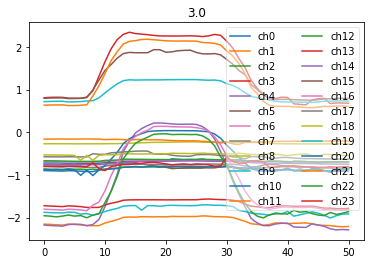

In [ ]:
idx = 4
ts, title = data.get_items()[idx]
show_timeseries(ts, title=title)
# show_timeseries(ts, title=title, chs=range(0,24,3)) 

In [ ]:
# hide
def load_from_tsfile_to_array(full_file_path_and_name, return_separate_X_and_y=True, replace_missing_vals_with='NaN'):
    """Loads data from a .ts file into a Pandas DataFrame.

    Parameters
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    return_separate_X_and_y: bool
        true if X and Y values should be returned as separate Data Frames (X) and a numpy array (y), false otherwise.
        This is only relevant for data that
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced with prior to parsing.

    Returns
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a numpy array containing the relevant time-series and            corresponding class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing all time-series and (if relevant) a column "class_vals"           the associated class values.
    """

    # Initialize flags and variables used when parsing the file

    metadata_started = False
    data_started = False

    has_problem_name_tag = False
    has_timestamps_tag = False
    has_univariate_tag = False
    has_class_labels_tag = False
    has_data_tag = False

    previous_timestamp_was_int = None
    previous_timestamp_was_timestamp = None
    num_dimensions = None
    is_first_case = True
    instance_list = []
    class_val_list = []
    line_num = 0

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, 'r',encoding='utf-8') as file:
        for line in file:
            # Strip white space from start/end of line and change to lowercase for use below
            line = line.strip().lower()
            # Empty lines are valid at any point in a file
            if line:
                # Check if this line contains metadata
                # Please note that even though metadata is stored in this function it is not currently published externally
                if line.startswith("@problemname"):
                    # Check that the data has not started
                    if data_started:
                        raise TsFileParseException("metadata must come before data")
                    # Check that the associated value is valid
                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("problemname tag requires an associated value")

                    problem_name = line[len("@problemname") + 1:]
                    has_problem_name_tag = True
                    metadata_started = True

                elif line.startswith("@timestamps"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len != 2:
                        raise TsFileParseException("timestamps tag requires an associated Boolean value")

                    elif tokens[1] == "true":
                        timestamps = True

                    elif tokens[1] == "false":
                        timestamps = False

                    else:
                        raise TsFileParseException("invalid timestamps value")

                    has_timestamps_tag = True
                    metadata_started = True

                elif line.startswith("@univariate"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len != 2:
                        raise TsFileParseException("univariate tag requires an associated Boolean value")

                    elif tokens[1] == "true":
                        univariate = True

                    elif tokens[1] == "false":
                        univariate = False

                    else:
                        raise TsFileParseException("invalid univariate value")

                    has_univariate_tag = True
                    metadata_started = True

                elif line.startswith("@classlabel"):

                    # Check that the data has not started

                    if data_started:
                        raise TsFileParseException("metadata must come before data")

                    # Check that the associated value is valid

                    tokens = line.split(' ')
                    token_len = len(tokens)

                    if token_len == 1:
                        raise TsFileParseException("classlabel tag requires an associated Boolean value")

                    if tokens[1] == "true":
                        class_labels = True

                    elif tokens[1] == "false":
                        class_labels = False

                    else:
                        raise TsFileParseException("invalid classLabel value")

                    # Check if we have any associated class values

                    if token_len == 2 and class_labels:
                        raise TsFileParseException("if the classlabel tag is true then class values must be supplied")

                    has_class_labels_tag = True
                    class_label_list = [token.strip() for token in tokens[2:]]
                    metadata_started = True

                # Check if this line contains the start of data

                elif line.startswith("@data"):

                    if line != "@data":
                        raise TsFileParseException("data tag should not have an associated value")

                    if data_started and not metadata_started:
                        raise TsFileParseException("metadata must come before data")

                    else:
                        has_data_tag = True
                        data_started = True

                # If the 'data tag has been found then metadata has been parsed and data can be loaded

                elif data_started:

                    # Check that a full set of metadata has been provided

                    if (not has_problem_name_tag or not has_timestamps_tag or not has_univariate_tag 
                        or not has_class_labels_tag or not has_data_tag):
                        raise TsFileParseException("a full set of metadata has not been provided before the data")

                    # Replace any missing values with the value specified

                    line = line.replace("?", replace_missing_vals_with)

                    # Check if we dealing with data that has timestamps

                    if timestamps:

                        # We're dealing with timestamps so cannot just split line on ':' as timestamps may contain one

                        has_another_value = False
                        has_another_dimension = False

                        timestamps_for_dimension = []
                        values_for_dimension = []

                        this_line_num_dimensions = 0
                        line_len = len(line)
                        char_num = 0

                        while char_num < line_len:

                            # Move through any spaces

                            while char_num < line_len and str.isspace(line[char_num]):
                                char_num += 1

                            # See if there is any more data to read in or if we should validate that read thus far

                            if char_num < line_len:

                                # See if we have an empty dimension (i.e. no values)

                                if line[char_num] == ":":
                                    if len(instance_list) < (this_line_num_dimensions + 1):
                                        instance_list.append([])

                                    instance_list[this_line_num_dimensions].append(pd.Series())
                                    this_line_num_dimensions += 1

                                    has_another_value = False
                                    has_another_dimension = True

                                    timestamps_for_dimension = []
                                    values_for_dimension = []

                                    char_num += 1

                                else:

                                    # Check if we have reached a class label

                                    if line[char_num] != "(" and class_labels:

                                        class_val = line[char_num:].strip()

                                        if class_val not in class_label_list:
                                            raise TsFileParseException("the class value '" + class_val + "' on line " + 
                                            str(line_num + 1) + " is not valid")

                                        class_val_list.append(class_val)
                                        char_num = line_len

                                        has_another_value = False
                                        has_another_dimension = False

                                        timestamps_for_dimension = []
                                        values_for_dimension = []

                                    else:

                                        # Read in the data contained within the next tuple

                                        if line[char_num] != "(" and not class_labels:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                                " on line " + str(line_num + 1) + " does not start with a '('")

                                        char_num += 1
                                        tuple_data = ""

                                        while char_num < line_len and line[char_num] != ")":
                                            tuple_data += line[char_num]
                                            char_num += 1

                                        if char_num >= line_len or line[char_num] != ")":
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) +
                                            " on line " + str(line_num + 1) + " does not end with a ')'")

                                        # Read in any spaces immediately after the current tuple

                                        char_num += 1

                                        while char_num < line_len and str.isspace(line[char_num]):
                                            char_num += 1

                                        # Check if there is another value or dimension to process after this tuple

                                        if char_num >= line_len:
                                            has_another_value = False
                                            has_another_dimension = False

                                        elif line[char_num] == ",":
                                            has_another_value = True
                                            has_another_dimension = False

                                        elif line[char_num] == ":":
                                            has_another_value = False
                                            has_another_dimension = True

                                        char_num += 1

                                        # Get the numeric value for the tuple by reading from the end of the tuple data backwards                                               to the last comma

                                        last_comma_index = tuple_data.rfind(',')

                                        if last_comma_index == -1:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                            " on line " + str(line_num + 1) + " contains a tuple that has no comma inside of it")

                                        try:
                                            value = tuple_data[last_comma_index + 1:]
                                            value = float(value)

                                        except ValueError:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                            " on line " + str(line_num + 1) + 
                                            " contains a tuple that does not have a valid numeric value")

                                        # Check the type of timestamp that we have

                                        timestamp = tuple_data[0: last_comma_index]

                                        try:
                                            timestamp = int(timestamp)
                                            timestamp_is_int = True
                                            timestamp_is_timestamp = False

                                        except ValueError:
                                            timestamp_is_int = False

                                        if not timestamp_is_int:
                                            try:
                                                timestamp = timestamp.strip()
                                                timestamp_is_timestamp = True

                                            except ValueError:
                                                timestamp_is_timestamp = False

                                        # Make sure that the timestamps in the file (not just this dimension or case) are consistent

                                        if not timestamp_is_timestamp and not timestamp_is_int:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                            " on line " + str(line_num + 1) + " contains a tuple that has an invalid timestamp '" + 
                                            timestamp + "'")

                                        if previous_timestamp_was_int is not None and previous_timestamp_was_int and \
                                         not timestamp_is_int:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                            " on line " + str(line_num + 1) + 
                                            " contains tuples where the timestamp format is inconsistent")

                                        if previous_timestamp_was_timestamp is not None and previous_timestamp_was_timestamp and \
                                        not timestamp_is_timestamp:
                                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) +
                                            " on line " + str(line_num + 1) + 
                                            " contains tuples where the timestamp format is inconsistent")

                                        # Store the values

                                        timestamps_for_dimension += [timestamp]
                                        values_for_dimension += [value]

                                        #  If this was our first tuple then we store the type of timestamp we had

                                        if previous_timestamp_was_timestamp is None and timestamp_is_timestamp:
                                            previous_timestamp_was_timestamp = True
                                            previous_timestamp_was_int = False

                                        if previous_timestamp_was_int is None and timestamp_is_int:
                                            previous_timestamp_was_timestamp = False
                                            previous_timestamp_was_int = True

                                        # See if we should add the data for this dimension

                                        if not has_another_value:
                                            if len(instance_list) < (this_line_num_dimensions + 1):
                                                instance_list.append([])

                                            if timestamp_is_timestamp:
                                                timestamps_for_dimension = pd.DatetimeIndex(timestamps_for_dimension)

                                            instance_list[this_line_num_dimensions].append(pd.Series(index=timestamps_for_dimension
                                            , data=values_for_dimension))
                                            this_line_num_dimensions += 1

                                            timestamps_for_dimension = []
                                            values_for_dimension = []

                            elif has_another_value:
                                raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                " on line " + str(line_num + 1) + " ends with a ',' that is not followed by another tuple")

                            elif has_another_dimension and class_labels:
                                raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                                " on line " + str(line_num + 1) + " ends with a ':' while it should list a class value")

                            elif has_another_dimension and not class_labels:
                                if len(instance_list) < (this_line_num_dimensions + 1):
                                    instance_list.append([])

                                instance_list[this_line_num_dimensions].append(pd.Series(dtype=np.float32))
                                this_line_num_dimensions += 1
                                num_dimensions = this_line_num_dimensions

                            # If this is the 1st line of data we have seen then note the dimensions

                            if not has_another_value and not has_another_dimension:
                                if num_dimensions is None:
                                    num_dimensions = this_line_num_dimensions

                                if num_dimensions != this_line_num_dimensions:
                                    raise TsFileParseException("line " + str(line_num + 1) + 
                                    " does not have the same number of dimensions as the previous line of data")

                        # Check that we are not expecting some more data, and if not, store that processed above

                        if has_another_value:
                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                            " on line " + str(line_num + 1) + " ends with a ',' that is not followed by another tuple")

                        elif has_another_dimension and class_labels:
                            raise TsFileParseException("dimension " + str(this_line_num_dimensions + 1) + 
                            " on line " + str(line_num + 1) + " ends with a ':' while it should list a class value")

                        elif has_another_dimension and not class_labels:
                            if len(instance_list) < (this_line_num_dimensions + 1):
                                instance_list.append([])

                            instance_list[this_line_num_dimensions].append(pd.Series())
                            this_line_num_dimensions += 1
                            num_dimensions = this_line_num_dimensions

                        # If this is the 1st line of data we have seen then note the dimensions

                        if not has_another_value and num_dimensions != this_line_num_dimensions:
                            raise TsFileParseException("line " + str(line_num + 1) + 
                            " does not have the same number of dimensions as the previous line of data")

                        # Check if we should have class values, and if so that they are contained in those listed in the metadata

                        if class_labels and len(class_val_list) == 0:
                            raise TsFileParseException("the cases have no associated class values")

                    else:
                        dimensions = line.split(":")

                        # If first row then note the number of dimensions (that must be the same for all cases)

                        if is_first_case:
                            num_dimensions = len(dimensions)

                            if class_labels:
                                num_dimensions -= 1

                            for dim in range(0, num_dimensions):
                                instance_list.append([])

                            is_first_case = False

                        # See how many dimensions that the case whose data in represented in this line has

                        this_line_num_dimensions = len(dimensions)

                        if class_labels:
                            this_line_num_dimensions -= 1

                        # All dimensions should be included for all series, even if they are empty

                        if this_line_num_dimensions != num_dimensions:
                            raise TsFileParseException("inconsistent number of dimensions")

                        # Process the data for each dimension

                        for dim in range(0, num_dimensions):
                            dimension = dimensions[dim].strip()

                            if dimension:
#                                 data_series = dimension.split(",")
#                                 data_series = [float(i) for i in data_series]
#                                 instance_list[dim].append(pd.Series(data_series))
                                
#                                 instance_list[dim].append(np.array(dimensions[dim].strip().split(','), dtype=np.float32))
                                instance_list[dim].append(np.array(dimensions[dim].split(','), dtype=np.float32))
#                                 instance_list[dim].append(np.fromiter(dimensions[dim].strip().split(','), dtype=np.float32))

                            else:
#                                 instance_list[dim].append(pd.Series())
                                instance_list[dim].append([])

                        if class_labels:
                            class_val_list.append(dimensions[num_dimensions].strip())

            line_num += 1

    # Check that the file was not empty

    if line_num:
        # Check that the file contained both metadata and data

        if metadata_started and not (has_problem_name_tag and has_timestamps_tag and has_univariate_tag and 
        has_class_labels_tag and has_data_tag):
            raise TsFileParseException("metadata incomplete")

        elif metadata_started and not data_started:
            raise TsFileParseException("file contained metadata but no data")

        elif metadata_started and data_started and len(instance_list) == 0:
            raise TsFileParseException("file contained metadata but no data")

#         # Create a DataFrame from the data parsed above

#         data = pd.DataFrame(dtype=np.float32)

#         for dim in range(0, num_dimensions):
#             data['dim_' + str(dim)] = instance_list[dim]

#         # Check if we should return any associated class labels separately

#         if class_labels:
#             if return_separate_X_and_y:
#                 return data, np.asarray(class_val_list)

#             else:
#                 data['class_vals'] = pd.Series(class_val_list)
#                 return data
#         else:
#             return data

        
        # Create a numpy array
            
        #instance_list has a shape of (dimensions, nb_samples, seq_lenght)
        #for the NATOPS_Train.arff it would be (24, 180, 51)
        #convert python list to numpy array and traspose the 2 first dimensions -> (180, 24, 51)
        data_array = np.asarray(instance_list).transpose(1,0,2) 
        y = np.asarray(class_val_list)

        return data_array, y
    

    else:
        raise TsFileParseException("empty file")


In [ ]:
fname_train = path_data/f'{dsname}/{dsname}_TRAIN.ts'
fname_train

Path('/home/farid/.fastai/data/NATOPS/NATOPS_TRAIN.ts')

In [ ]:
train_x_ts, train_y_ts = load_from_tsfile_to_array(fname_train)
train_x_ts.shape, train_y_ts.shape

((180, 24, 51), (180,))

In [ ]:
train_x_ts[1].shape

(24, 51)

In [ ]:
train_x_ts[10][0][30]

0.445743

In [ ]:
#export
def get_UCR_univariate_list():
    return [
        'ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY',
        'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken',
        'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration',
        'CinCECGtorso', 'Coffee', 'Computers', 'CricketX', 'CricketY',
        'CricketZ', 'Crop', 'DiatomSizeReduction',
        'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect',
        'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame',
        'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays',
        'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal',
        'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords',
        'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain',
        'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3',
        'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan',
        'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham',
        'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate',
        'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound',
        'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2',
        'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian',
        'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect',
        'MiddlePhalanxTW', 'MixedShapes', 'MixedShapesSmallTrain',
        'MoteStrain', 'NonInvasiveFetalECGThorax1',
        'NonInvasiveFetalECGThorax2', 'OliveOil', 'OSULeaf',
        'PhalangesOutlinesCorrect', 'Phoneme', 'PickupGestureWiimoteZ',
        'PigAirwayPressure', 'PigArtPressure', 'PigCVP', 'PLAID', 'Plane',
        'PowerCons', 'ProximalPhalanxOutlineAgeGroup',
        'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW',
        'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2',
        'SemgHandMovementCh2', 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ',
        'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace',
        'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarlightCurves',
        'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl',
        'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG',
        'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll', 'UWaveGestureLibraryX',
        'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Wine',
        'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga'
    ]

def get_UCR_multivariate_list():
    return [
        'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions',
        'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms',
        'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection',
        'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat',
        'JapaneseVowels', 'Libras', 'LSST', 'InsectWingbeat', 'MotorImagery',
        'NATOPS', 'PenDigits', 'PEMS-SF', 'PhonemeSpectra', 'RacketSports',
        'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits',
        'StandWalkJump', 'UWaveGestureLibrary'
    ]

In [ ]:
# hide
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    "Convert CamelCase to snake_case"
    s1   = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

def camel2capitalsnake(name):
    return camel2snake(name).upper()

In [ ]:
# hide
# urls_ts = [f'{camel2capitalsnake(n)} = {n}.zip'     for n in get_UCR_multivariate_list()]
# urls_ts

In [ ]:
 #hide   
    # MULTI_ARTICULARY_WORD_RECOGNITION = f'{URL}ArticularyWordRecognition.zip',
    # MULTI_ATRIAL_FIBRILLATION = f'{URL}AtrialFibrillation.zip',
    # MULTI_BASIC_MOTIONS = f'{URL}BasicMotions.zip',
    # MULTI_CHARACTER_TRAJECTORIES = f'{URL}CharacterTrajectories.zip',
    # MULTI_CRICKET = f'{URL}Cricket.zip',
    # MULTI_DUCK_DUCK_GEESE = f'{URL}DuckDuckGeese.zip',
    # MULTI_EIGEN_WORMS = f'{URL}EigenWorms.zip',
    # MULTI_EPILEPSY = f'{URL}Epilepsy.zip',
    # MULTI_ETHANOL_CONCENTRATION = f'{URL}EthanolConcentration.zip',
    # MULTI_ERING = f'{URL}ERing.zip',
    # MULTI_FACE_DETECTION = f'{URL}FaceDetection.zip',
    # MULTI_FINGER_MOVEMENTS = f'{URL}FingerMovements.zip',
    # MULTI_HAND_MOVEMENT_DIRECTION = f'{URL}HandMovementDirection.zip',
    # MULTI_HANDWRITING = f'{URL}Handwriting.zip',
    # MULTI_HEARTBEAT = f'{URL}Heartbeat.zip',
    # MULTI_JAPANESE_VOWELS = f'{URL}JapaneseVowels.zip',
    # MULTI_LIBRAS = f'{URL}Libras.zip',
    # MULTI_LSST = f'{URL}LSST.zip',
    # MULTI_INSECT_WINGBEAT = f'{URL}InsectWingbeat.zip',
    # MULTI_MOTOR_IMAGERY = f'{URL}MotorImagery.zip',
    # MULTI_NATOPS = f'{URL}NATOPS.zip',
    # MULTI_PEN_DIGITS = f'{URL}PenDigits.zip',
    # MULTI_PEMS-SF = f'{URL}PEMS-SF.zip',
    # MULTI_PHONEME_SPECTRA = f'{URL}PhonemeSpectra.zip',
    # MULTI_RACKET_SPORTS = f'{URL}RacketSports.zip',
    # MULTI_SELF_REGULATION_SCP1 = f'{URL}SelfRegulationSCP1.zip',
    # MULTI_SELF_REGULATION_SCP2 = f'{URL}SelfRegulationSCP2.zip',
    # MULTI_SPOKEN_ARABIC_DIGITS = f'{URL}SpokenArabicDigits.zip',
    # MULTI_STAND_WALK_JUMP = f'{URL}StandWalkJump.zip',
    # MULTI_U_WAVE_GESTURE_LIBRARY = f'{URL}UWaveGestureLibrary'

In [ ]:
# hide
# urls_ts = [f'{camel2capitalsnake(n)} = {n}.zip'     for n in get_UCR_univariate_list()]
# urls_ts

In [ ]:
# hide
    # UNI_ACSF1 = f'{URL}ACSF1.zip,
    # UNI_ADIAC = f'{URL}Adiac.zip,
    # UNI_ALL_GESTURE_WIIMOTE_X = f'{URL}AllGestureWiimoteX.zip,
    # UNI_ALL_GESTURE_WIIMOTE_Y = f'{URL}AllGestureWiimoteY.zip,
    # UNI_ALL_GESTURE_WIIMOTE_Z = f'{URL}AllGestureWiimoteZ.zip,
    # UNI_ARROW_HEAD = f'{URL}ArrowHead.zip,
    # UNI_BEEF = f'{URL}Beef.zip,
    # UNI_BEETLE_FLY = f'{URL}BeetleFly.zip,
    # UNI_BIRD_CHICKEN = f'{URL}BirdChicken.zip,
    # UNI_BME = f'{URL}BME.zip,
    # UNI_CAR = f'{URL}Car.zip,
    # UNI_CBF = f'{URL}CBF.zip,
    # UNI_CHINATOWN = f'{URL}Chinatown.zip,
    # UNI_CHLORINE_CONCENTRATION = f'{URL}ChlorineConcentration.zip,
    # UNI_CIN_CEC_GTORSO = f'{URL}CinCECGtorso.zip,
    # UNI_COFFEE = f'{URL}Coffee.zip,
    # UNI_COMPUTERS = f'{URL}Computers.zip,
    # UNI_CRICKET_X = f'{URL}CricketX.zip,
    # UNI_CRICKET_Y = f'{URL}CricketY.zip,
    # UNI_CRICKET_Z = f'{URL}CricketZ.zip,
    # UNI_CROP = f'{URL}Crop.zip,
    # UNI_DIATOM_SIZE_REDUCTION = f'{URL}DiatomSizeReduction.zip,
    # UNI_DISTAL_PHALANX_OUTLINE_AGE_GROUP = f'{URL}DistalPhalanxOutlineAgeGroup.zip,
    # UNI_DISTAL_PHALANX_OUTLINE_CORRECT = f'{URL}DistalPhalanxOutlineCorrect.zip,
    # UNI_DISTAL_PHALANX_TW = f'{URL}DistalPhalanxTW.zip,
    # UNI_DODGER_LOOP_DAY = f'{URL}DodgerLoopDay.zip,
    # UNI_DODGER_LOOP_GAME = f'{URL}DodgerLoopGame.zip,
    # UNI_DODGER_LOOP_WEEKEND = f'{URL}DodgerLoopWeekend.zip,
    # UNI_EARTHQUAKES = f'{URL}Earthquakes.zip,
    # UNI_ECG200 = f'{URL}ECG200.zip,
    # UNI_ECG5000 = f'{URL}ECG5000.zip,
    # UNI_ECG_FIVE_DAYS = f'{URL}ECGFiveDays.zip,
    # UNI_ELECTRIC_DEVICES = f'{URL}ElectricDevices.zip,
    # UNI_EOG_HORIZONTAL_SIGNAL = f'{URL}EOGHorizontalSignal.zip,
    # UNI_EOG_VERTICAL_SIGNAL = f'{URL}EOGVerticalSignal.zip,
    # UNI_ETHANOL_LEVEL = f'{URL}EthanolLevel.zip,
    # UNI_FACE_ALL = f'{URL}FaceAll.zip,
    # UNI_FACE_FOUR = f'{URL}FaceFour.zip,
    # UNI_FACES_UCR = f'{URL}FacesUCR.zip,
    # UNI_FIFTY_WORDS = f'{URL}FiftyWords.zip,
    # UNI_FISH = f'{URL}Fish.zip,
    # UNI_FORD_A = f'{URL}FordA.zip,
    # UNI_FORD_B = f'{URL}FordB.zip,
    # UNI_FREEZER_REGULAR_TRAIN = f'{URL}FreezerRegularTrain.zip,
    # UNI_FREEZER_SMALL_TRAIN = f'{URL}FreezerSmallTrain.zip,
    # UNI_FUNGI = f'{URL}Fungi.zip,
    # UNI_GESTURE_MID_AIR_D1 = f'{URL}GestureMidAirD1.zip,
    # UNI_GESTURE_MID_AIR_D2 = f'{URL}GestureMidAirD2.zip,
    # UNI_GESTURE_MID_AIR_D3 = f'{URL}GestureMidAirD3.zip,
    # UNI_GESTURE_PEBBLE_Z1 = f'{URL}GesturePebbleZ1.zip,
    # UNI_GESTURE_PEBBLE_Z2 = f'{URL}GesturePebbleZ2.zip,
    # UNI_GUN_POINT = f'{URL}GunPoint.zip,
    # UNI_GUN_POINT_AGE_SPAN = f'{URL}GunPointAgeSpan.zip,
    # UNI_GUN_POINT_MALE_VERSUS_FEMALE = f'{URL}GunPointMaleVersusFemale.zip,
    # UNI_GUN_POINT_OLD_VERSUS_YOUNG = f'{URL}GunPointOldVersusYoung.zip,
    # UNI_HAM = f'{URL}Ham.zip,
    # UNI_HAND_OUTLINES = f'{URL}HandOutlines.zip,
    # UNI_HAPTICS = f'{URL}Haptics.zip,
    # UNI_HERRING = f'{URL}Herring.zip,
    # UNI_HOUSE_TWENTY = f'{URL}HouseTwenty.zip,
    # UNI_INLINE_SKATE = f'{URL}InlineSkate.zip,
    # UNI_INSECT_EPG_REGULAR_TRAIN = f'{URL}InsectEPGRegularTrain.zip,
    # UNI_INSECT_EPG_SMALL_TRAIN = f'{URL}InsectEPGSmallTrain.zip,
    # UNI_INSECT_WINGBEAT_SOUND = f'{URL}InsectWingbeatSound.zip,
    # UNI_ITALY_POWER_DEMAND = f'{URL}ItalyPowerDemand.zip,
    # UNI_LARGE_KITCHEN_APPLIANCES = f'{URL}LargeKitchenAppliances.zip,
    # UNI_LIGHTNING2 = f'{URL}Lightning2.zip,
    # UNI_LIGHTNING7 = f'{URL}Lightning7.zip,
    # UNI_MALLAT = f'{URL}Mallat.zip,
    # UNI_MEAT = f'{URL}Meat.zip,
    # UNI_MEDICAL_IMAGES = f'{URL}MedicalImages.zip,
    # UNI_MELBOURNE_PEDESTRIAN = f'{URL}MelbournePedestrian.zip,
    # UNI_MIDDLE_PHALANX_OUTLINE_AGE_GROUP = f'{URL}MiddlePhalanxOutlineAgeGroup.zip,
    # UNI_MIDDLE_PHALANX_OUTLINE_CORRECT = f'{URL}MiddlePhalanxOutlineCorrect.zip,
    # UNI_MIDDLE_PHALANX_TW = f'{URL}MiddlePhalanxTW.zip,
    # UNI_MIXED_SHAPES = f'{URL}MixedShapes.zip,
    # UNI_MIXED_SHAPES_SMALL_TRAIN = f'{URL}MixedShapesSmallTrain.zip,
    # UNI_MOTE_STRAIN = f'{URL}MoteStrain.zip,
    # UNI_NON_INVASIVE_FETAL_ECG_THORAX1 = f'{URL}NonInvasiveFetalECGThorax1.zip,
    # UNI_NON_INVASIVE_FETAL_ECG_THORAX2 = f'{URL}NonInvasiveFetalECGThorax2.zip,
    # UNI_OLIVE_OIL = f'{URL}OliveOil.zip,
    # UNI_OSU_LEAF = f'{URL}OSULeaf.zip,
    # UNI_PHALANGES_OUTLINES_CORRECT = f'{URL}PhalangesOutlinesCorrect.zip,
    # UNI_PHONEME = f'{URL}Phoneme.zip,
    # UNI_PICKUP_GESTURE_WIIMOTE_Z = f'{URL}PickupGestureWiimoteZ.zip,
    # UNI_PIG_AIRWAY_PRESSURE = f'{URL}PigAirwayPressure.zip,
    # UNI_PIG_ART_PRESSURE = f'{URL}PigArtPressure.zip,
    # UNI_PIG_CVP = f'{URL}PigCVP.zip,
    # UNI_PLAID = f'{URL}PLAID.zip,
    # UNI_PLANE = f'{URL}Plane.zip,
    # UNI_POWER_CONS = f'{URL}PowerCons.zip,
    # UNI_PROXIMAL_PHALANX_OUTLINE_AGE_GROUP = f'{URL}ProximalPhalanxOutlineAgeGroup.zip,
    # UNI_PROXIMAL_PHALANX_OUTLINE_CORRECT = f'{URL}ProximalPhalanxOutlineCorrect.zip,
    # UNI_PROXIMAL_PHALANX_TW = f'{URL}ProximalPhalanxTW.zip,
    # UNI_REFRIGERATION_DEVICES = f'{URL}RefrigerationDevices.zip,
    # UNI_ROCK = f'{URL}Rock.zip,
    # UNI_SCREEN_TYPE = f'{URL}ScreenType.zip,
    # UNI_SEMG_HAND_GENDER_CH2 = f'{URL}SemgHandGenderCh2.zip,
    # UNI_SEMG_HAND_MOVEMENT_CH2 = f'{URL}SemgHandMovementCh2.zip,
    # UNI_SEMG_HAND_SUBJECT_CH2 = f'{URL}SemgHandSubjectCh2.zip,
    # UNI_SHAKE_GESTURE_WIIMOTE_Z = f'{URL}ShakeGestureWiimoteZ.zip,
    # UNI_SHAPELET_SIM = f'{URL}ShapeletSim.zip,
    # UNI_SHAPES_ALL = f'{URL}ShapesAll.zip,
    # UNI_SMALL_KITCHEN_APPLIANCES = f'{URL}SmallKitchenAppliances.zip,
    # UNI_SMOOTH_SUBSPACE = f'{URL}SmoothSubspace.zip,
    # UNI_SONY_AIBO_ROBOT_SURFACE1 = f'{URL}SonyAIBORobotSurface1.zip,
    # UNI_SONY_AIBO_ROBOT_SURFACE2 = f'{URL}SonyAIBORobotSurface2.zip,
    # UNI_STARLIGHT_CURVES = f'{URL}StarlightCurves.zip,
    # UNI_STRAWBERRY = f'{URL}Strawberry.zip,
    # UNI_SWEDISH_LEAF = f'{URL}SwedishLeaf.zip,
    # UNI_SYMBOLS = f'{URL}Symbols.zip,
    # UNI_SYNTHETIC_CONTROL = f'{URL}SyntheticControl.zip,
    # UNI_TOE_SEGMENTATION1 = f'{URL}ToeSegmentation1.zip,
    # UNI_TOE_SEGMENTATION2 = f'{URL}ToeSegmentation2.zip,
    # UNI_TRACE = f'{URL}Trace.zip,
    # UNI_TWO_LEAD_ECG = f'{URL}TwoLeadECG.zip,
    # UNI_TWO_PATTERNS = f'{URL}TwoPatterns.zip,
    # UNI_UMD = f'{URL}UMD.zip,
    # UNI_U_WAVE_GESTURE_LIBRARY_ALL = f'{URL}UWaveGestureLibraryAll.zip,
    # UNI_U_WAVE_GESTURE_LIBRARY_X = f'{URL}UWaveGestureLibraryX.zip,
    # UNI_U_WAVE_GESTURE_LIBRARY_Y = f'{URL}UWaveGestureLibraryY.zip,
    # UNI_U_WAVE_GESTURE_LIBRARY_Z = f'{URL}UWaveGestureLibraryZ.zip,
    # UNI_WAFER = f'{URL}Wafer.zip,
    # UNI_WINE = f'{URL}Wine.zip,
    # UNI_WORD_SYNONYMS = f'{URL}WordSynonyms.zip,
    # UNI_WORMS = f'{URL}Worms.zip,
    # UNI_WORMS_TWO_CLASS = f'{URL}WormsTwoClass.zip,
    # UNI_YOGA = f'{URL}Yoga.zipUNI_

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
# notebook2script(fname='80_timeseries_data.ipynb')

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted 82_univariate_timeseries_CAM.ipynb.
Converted Colab_timeseries_Tutorial.ipynb.
Converted cam_tutorial_ECG200.ipynb.
Converted cam_tutorial_GunPoint.ipynb.
Converted index.ipynb.
Converted inference_tuorial.ipynb.
Converted inference_voila.ipynb.
Converted training_using_default_settings.ipynb.
Converted univariate_timeseries_Tutorial.ipynb.


<img src="https://github.com/ai-fast-track/timeseries/blob/master/images/blue-sea.jpg?raw=1" alt=""/>